# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [2]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import cv2
import matplotlib.pyplot as plt


# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# DEEPSORT_DIR = os.path.join(ROOT_DIR,'deep_sort')
# sys.path.append(DEEPSORT_DIR)
# from application_util import preprocessing
# from deep_sort.tracker import Tracker
# from deep_sort.detection import Detection
# from deep_sort import nn_matching
# from deep_sort.detection import Detection as ddet
# import tools.generate_detections as gdet

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

/Users/wukailei/anaconda3/envs/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/wukailei/anaconda3/envs/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/wukailei/anaconda3/envs/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/wukailei/anaconda3/envs/

ModuleNotFoundError: No module named 'utils'

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [1]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

NameError: name 'coco' is not defined

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Object Tracking

In [5]:
trackerTypes = ['BOOSTING', 'MIL', 'KCF','TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']
def createTrackerByName(trackerType):
  # Create a tracker based on tracker name
  if trackerType == trackerTypes[0]:
    tracker = cv2.TrackerBoosting_create()
  elif trackerType == trackerTypes[1]: 
    tracker = cv2.TrackerMIL_create()
  elif trackerType == trackerTypes[2]:
    tracker = cv2.TrackerKCF_create()
  elif trackerType == trackerTypes[3]:
    tracker = cv2.TrackerTLD_create()
  elif trackerType == trackerTypes[4]:
    tracker = cv2.TrackerMedianFlow_create()
  elif trackerType == trackerTypes[5]:
    tracker = cv2.TrackerGOTURN_create()
  elif trackerType == trackerTypes[6]:
    tracker = cv2.TrackerMOSSE_create()
  elif trackerType == trackerTypes[7]:
    tracker = cv2.TrackerCSRT_create()
  else:
    tracker = None
    print('Incorrect tracker name')
    print('Available trackers are:')
    for t in trackerTypes:
      print(t)
     
  return tracker

In [6]:
os.getcwd()

'/Users/wukailei/Documents/study/Australia/2020_summer/gitcode/working/autoportraitfilter/prototype/mask_cnn/samples'

In [30]:
videoPath = "run.mp4"
 
# Create a video capture object to read videos
capture = cv2.VideoCapture(videoPath)
 
# Read first frame
success, frame = capture.read()
# quit if unable to read the video file
if not success:
    print('Failed to read video')
    sys.exit(1)

In [31]:
bboxes = []
colors = [] 
# OpenCV's selectROI function doesn't work for selecting multiple objects in Python
# So we will call this function in a loop till we are done selecting all objects
while True:
    results = model.detect([frame], verbose=0)
    bbox = results[0]['rois']
    bboxes.append(bbox)
    print("Press q to quit selecting boxes and start tracking")
    print("Press any other key to select next object")
    k = cv2.waitKey(0) & 0xFF
    if (k == 113):  # q is pressed
        break

    print('Selected bounding boxes {}'.format(bboxes))

Press q to quit selecting boxes and start tracking
Press any other key to select next object
Selected bounding boxes [array([[341,  80, 398, 121],
       [241, 173, 315, 199],
       [260, 686, 340, 708],
       [329, 123, 398, 167],
       [258, 376, 351, 406],
       [282, 309, 385, 348],
       [ 55, 155, 146, 236],
       [296, 198, 379, 230],
       [161, 389, 208, 407],
       [378, 408, 400, 437],
       [234, 223, 305, 249],
       [352, 361, 400, 394],
       [206, 500, 262, 525],
       [220, 431, 275, 470],
       [117,  49, 229, 157],
       [ 96, 374, 141, 394],
       [188, 461, 250, 484],
       [ 87, 322, 128, 339],
       [ 56, 361, 103, 382],
       [ 77, 263, 121, 285],
       [ 97, 127, 160, 158],
       [ 54, 349,  98, 362],
       [132, 321, 172, 337],
       [174, 426, 230, 446],
       [162, 157, 232, 180],
       [ 35, 215,  90, 269],
       [139, 274, 188, 295],
       [251, 708, 332, 720],
       [ 63, 333, 107, 348],
       [297, 258, 375, 286],
       [ 27,

Press q to quit selecting boxes and start tracking
Press any other key to select next object
Selected bounding boxes [array([[341,  80, 398, 121],
       [241, 173, 315, 199],
       [260, 686, 340, 708],
       [329, 123, 398, 167],
       [258, 376, 351, 406],
       [282, 309, 385, 348],
       [ 55, 155, 146, 236],
       [296, 198, 379, 230],
       [161, 389, 208, 407],
       [378, 408, 400, 437],
       [234, 223, 305, 249],
       [352, 361, 400, 394],
       [206, 500, 262, 525],
       [220, 431, 275, 470],
       [117,  49, 229, 157],
       [ 96, 374, 141, 394],
       [188, 461, 250, 484],
       [ 87, 322, 128, 339],
       [ 56, 361, 103, 382],
       [ 77, 263, 121, 285],
       [ 97, 127, 160, 158],
       [ 54, 349,  98, 362],
       [132, 321, 172, 337],
       [174, 426, 230, 446],
       [162, 157, 232, 180],
       [ 35, 215,  90, 269],
       [139, 274, 188, 295],
       [251, 708, 332, 720],
       [ 63, 333, 107, 348],
       [297, 258, 375, 286],
       [ 27,

Press q to quit selecting boxes and start tracking
Press any other key to select next object
Selected bounding boxes [array([[341,  80, 398, 121],
       [241, 173, 315, 199],
       [260, 686, 340, 708],
       [329, 123, 398, 167],
       [258, 376, 351, 406],
       [282, 309, 385, 348],
       [ 55, 155, 146, 236],
       [296, 198, 379, 230],
       [161, 389, 208, 407],
       [378, 408, 400, 437],
       [234, 223, 305, 249],
       [352, 361, 400, 394],
       [206, 500, 262, 525],
       [220, 431, 275, 470],
       [117,  49, 229, 157],
       [ 96, 374, 141, 394],
       [188, 461, 250, 484],
       [ 87, 322, 128, 339],
       [ 56, 361, 103, 382],
       [ 77, 263, 121, 285],
       [ 97, 127, 160, 158],
       [ 54, 349,  98, 362],
       [132, 321, 172, 337],
       [174, 426, 230, 446],
       [162, 157, 232, 180],
       [ 35, 215,  90, 269],
       [139, 274, 188, 295],
       [251, 708, 332, 720],
       [ 63, 333, 107, 348],
       [297, 258, 375, 286],
       [ 27,

Press q to quit selecting boxes and start tracking
Press any other key to select next object
Selected bounding boxes [array([[341,  80, 398, 121],
       [241, 173, 315, 199],
       [260, 686, 340, 708],
       [329, 123, 398, 167],
       [258, 376, 351, 406],
       [282, 309, 385, 348],
       [ 55, 155, 146, 236],
       [296, 198, 379, 230],
       [161, 389, 208, 407],
       [378, 408, 400, 437],
       [234, 223, 305, 249],
       [352, 361, 400, 394],
       [206, 500, 262, 525],
       [220, 431, 275, 470],
       [117,  49, 229, 157],
       [ 96, 374, 141, 394],
       [188, 461, 250, 484],
       [ 87, 322, 128, 339],
       [ 56, 361, 103, 382],
       [ 77, 263, 121, 285],
       [ 97, 127, 160, 158],
       [ 54, 349,  98, 362],
       [132, 321, 172, 337],
       [174, 426, 230, 446],
       [162, 157, 232, 180],
       [ 35, 215,  90, 269],
       [139, 274, 188, 295],
       [251, 708, 332, 720],
       [ 63, 333, 107, 348],
       [297, 258, 375, 286],
       [ 27,

Press q to quit selecting boxes and start tracking
Press any other key to select next object
Selected bounding boxes [array([[341,  80, 398, 121],
       [241, 173, 315, 199],
       [260, 686, 340, 708],
       [329, 123, 398, 167],
       [258, 376, 351, 406],
       [282, 309, 385, 348],
       [ 55, 155, 146, 236],
       [296, 198, 379, 230],
       [161, 389, 208, 407],
       [378, 408, 400, 437],
       [234, 223, 305, 249],
       [352, 361, 400, 394],
       [206, 500, 262, 525],
       [220, 431, 275, 470],
       [117,  49, 229, 157],
       [ 96, 374, 141, 394],
       [188, 461, 250, 484],
       [ 87, 322, 128, 339],
       [ 56, 361, 103, 382],
       [ 77, 263, 121, 285],
       [ 97, 127, 160, 158],
       [ 54, 349,  98, 362],
       [132, 321, 172, 337],
       [174, 426, 230, 446],
       [162, 157, 232, 180],
       [ 35, 215,  90, 269],
       [139, 274, 188, 295],
       [251, 708, 332, 720],
       [ 63, 333, 107, 348],
       [297, 258, 375, 286],
       [ 27,

Press q to quit selecting boxes and start tracking
Press any other key to select next object
Selected bounding boxes [array([[341,  80, 398, 121],
       [241, 173, 315, 199],
       [260, 686, 340, 708],
       [329, 123, 398, 167],
       [258, 376, 351, 406],
       [282, 309, 385, 348],
       [ 55, 155, 146, 236],
       [296, 198, 379, 230],
       [161, 389, 208, 407],
       [378, 408, 400, 437],
       [234, 223, 305, 249],
       [352, 361, 400, 394],
       [206, 500, 262, 525],
       [220, 431, 275, 470],
       [117,  49, 229, 157],
       [ 96, 374, 141, 394],
       [188, 461, 250, 484],
       [ 87, 322, 128, 339],
       [ 56, 361, 103, 382],
       [ 77, 263, 121, 285],
       [ 97, 127, 160, 158],
       [ 54, 349,  98, 362],
       [132, 321, 172, 337],
       [174, 426, 230, 446],
       [162, 157, 232, 180],
       [ 35, 215,  90, 269],
       [139, 274, 188, 295],
       [251, 708, 332, 720],
       [ 63, 333, 107, 348],
       [297, 258, 375, 286],
       [ 27,

Press q to quit selecting boxes and start tracking
Press any other key to select next object
Selected bounding boxes [array([[341,  80, 398, 121],
       [241, 173, 315, 199],
       [260, 686, 340, 708],
       [329, 123, 398, 167],
       [258, 376, 351, 406],
       [282, 309, 385, 348],
       [ 55, 155, 146, 236],
       [296, 198, 379, 230],
       [161, 389, 208, 407],
       [378, 408, 400, 437],
       [234, 223, 305, 249],
       [352, 361, 400, 394],
       [206, 500, 262, 525],
       [220, 431, 275, 470],
       [117,  49, 229, 157],
       [ 96, 374, 141, 394],
       [188, 461, 250, 484],
       [ 87, 322, 128, 339],
       [ 56, 361, 103, 382],
       [ 77, 263, 121, 285],
       [ 97, 127, 160, 158],
       [ 54, 349,  98, 362],
       [132, 321, 172, 337],
       [174, 426, 230, 446],
       [162, 157, 232, 180],
       [ 35, 215,  90, 269],
       [139, 274, 188, 295],
       [251, 708, 332, 720],
       [ 63, 333, 107, 348],
       [297, 258, 375, 286],
       [ 27,

KeyboardInterrupt: 

In [2]:
im = cv2.imread("image.jpg")

In [32]:
# Specify the tracker type
trackerType = "KCF"   

# Create MultiTracker object
multiTracker = cv2.MultiTracker_create()
 
# Initialize MultiTracker 
for bbox in bboxes:
    multiTracker.add(createTrackerByName(trackerType), frame, bbox)

SystemError: new style getargs format but argument is not a tuple

In [ ]:
# Process video and track objects
while capture.isOpened():
    success, frame = capture.read()
    if not success:
    break
   
  # get updated location of objects in subsequent frames
    success, boxes = multiTracker.update(frame)
 
  # draw tracked objects
    for i, newbox in enumerate(boxes):
        p1 = (int(newbox[0]), int(newbox[1]))
        p2 = (int(newbox[0] + newbox[2]), int(newbox[1] + newbox[3]))
        cv2.rectangle(frame, p1, p2, colors[i], 2, 1)
        
 
  # show frame
    cv2.imshow('MultiTracker', frame)
   
 
  # quit on ESC button
    if cv2.waitKey(1) & 0xFF == 27:  # Esc pressed
        break

In [19]:
bbox = results[0]['rois']

## Run Object Detection

In [33]:
boxs = results[0]['rois']

Processing 1 images
image                    shape: (394, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


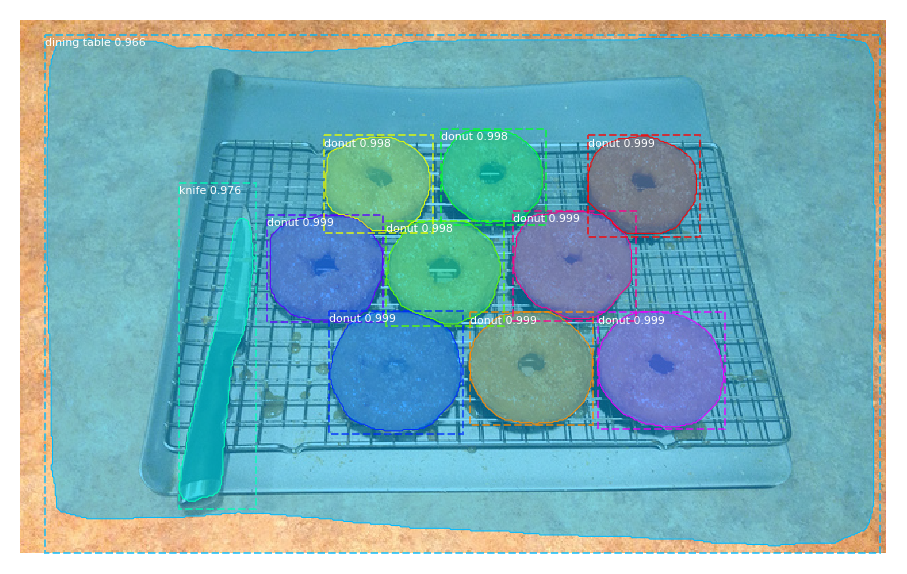

In [35]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [10]:
#!/usr/bin/python
#
# Copyright 2018 BIG VISION LLC ALL RIGHTS RESERVED
# 
from __future__ import print_function
import sys
import cv2
from random import randint

trackerTypes = ['BOOSTING', 'MIL', 'KCF','TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']

def createTrackerByName(trackerType):
  # Create a tracker based on tracker name
  if trackerType == trackerTypes[0]:
    tracker = cv2.TrackerBoosting_create()
  elif trackerType == trackerTypes[1]: 
    tracker = cv2.TrackerMIL_create()
  elif trackerType == trackerTypes[2]:
    tracker = cv2.TrackerKCF_create()
  elif trackerType == trackerTypes[3]:
    tracker = cv2.TrackerTLD_create()
  elif trackerType == trackerTypes[4]:
    tracker = cv2.TrackerMedianFlow_create()
  elif trackerType == trackerTypes[5]:
    tracker = cv2.TrackerGOTURN_create()
  elif trackerType == trackerTypes[6]:
    tracker = cv2.TrackerMOSSE_create()
  elif trackerType == trackerTypes[7]:
    tracker = cv2.TrackerCSRT_create()
  else:
    tracker = None
    print('Incorrect tracker name')
    print('Available trackers are:')
    for t in trackerTypes:
      print(t)
    
  return tracker

if __name__ == '__main__':

  print("Default tracking algoritm is CSRT \n"
        "Available tracking algorithms are:\n")
  for t in trackerTypes:
      print(t)      

  trackerType = "CSRT"      

  # Set video to load
  videoPath = "videos/run.mp4"
  
  # Create a video capture object to read videos
  cap = cv2.VideoCapture(videoPath)
 
  # Read first frame
  success, frame = cap.read()
  # quit if unable to read the video file
  if not success:
    print('Failed to read video')
    sys.exit(1)

  ## Select boxes
  bboxes = []
  colors = [] 

  # OpenCV's selectROI function doesn't work for selecting multiple objects in Python
  # So we will call this function in a loop till we are done selecting all objects
  while True:
    # draw bounding boxes over objects
    # selectROI's default behaviour is to draw box starting from the center
    # when fromCenter is set to false, you can draw box starting from top left corner
    bbox = cv2.selectROI('MultiTracker', frame)
    bboxes.append(bbox)
    colors.append((randint(64, 255), randint(64, 255), randint(64, 255)))
    print("Press q to quit selecting boxes and start tracking")
    print("Press any other key to select next object")
    k = cv2.waitKey(0) & 0xFF
    if (k == 113):  # q is pressed
      break
  
  print('Selected bounding boxes {}'.format(bboxes))

  ## Initialize MultiTracker
  # There are two ways you can initialize multitracker
  # 1. tracker = cv2.MultiTracker("CSRT")
  # All the trackers added to this multitracker
  # will use CSRT algorithm as default
  # 2. tracker = cv2.MultiTracker()
  # No default algorithm specified

  # Initialize MultiTracker with tracking algo
  # Specify tracker type
  
  # Create MultiTracker object
  multiTracker = cv2.MultiTracker_create()

  # Initialize MultiTracker 
  for bbox in bboxes:
    multiTracker.add(createTrackerByName(trackerType), frame, bbox)


  # Process video and track objects
  while cap.isOpened():
    success, frame = cap.read()
    if not success:
      break
    
    # get updated location of objects in subsequent frames
    success, boxes = multiTracker.update(frame)

    # draw tracked objects
    for i, newbox in enumerate(boxes):
      p1 = (int(newbox[0]), int(newbox[1]))
      p2 = (int(newbox[0] + newbox[2]), int(newbox[1] + newbox[3]))
      cv2.rectangle(frame, p1, p2, colors[i], 2, 1)

    # show frame
    cv2.imshow('MultiTracker', frame)
    

    # quit on ESC button
    if cv2.waitKey(1) & 0xFF == 27:  # Esc pressed
      break


Default tracking algoritm is CSRT 
Available tracking algorithms are:

BOOSTING
MIL
KCF
TLD
MEDIANFLOW
GOTURN
MOSSE
CSRT
Failed to read video


SystemExit: 1

In [12]:
#!/usr/bin/python
#
# Copyright 2018 BIG VISION LLC ALL RIGHTS RESERVED
#
from __future__ import print_function
import sys
import cv2
from random import randint

trackerTypes = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']


def createTrackerByName(trackerType):
    # Create a tracker based on tracker name
    if trackerType == trackerTypes[0]:
        tracker = cv2.TrackerBoosting_create()
    elif trackerType == trackerTypes[1]:
        tracker = cv2.TrackerMIL_create()
    elif trackerType == trackerTypes[2]:
        tracker = cv2.TrackerKCF_create()
    elif trackerType == trackerTypes[3]:
        tracker = cv2.TrackerTLD_create()
    elif trackerType == trackerTypes[4]:
        tracker = cv2.TrackerMedianFlow_create()
    elif trackerType == trackerTypes[5]:
        tracker = cv2.TrackerGOTURN_create()
    elif trackerType == trackerTypes[6]:
        tracker = cv2.TrackerMOSSE_create()
    elif trackerType == trackerTypes[7]:
        tracker = cv2.TrackerCSRT_create()
    else:
        tracker = None
        print('Incorrect tracker name')
        print('Available trackers are:')
        for t in trackerTypes:
            print(t)

    return tracker


    print("Default tracking algoritm is CSRT \n"
          "Available tracking algorithms are:\n")
    for t in trackerTypes:
        print(t)

    trackerType = "CSRT"

    # Set video to load

    # Create a video capture object to read videos
    cap = cv2.VideoCapture("run.mp4")

    # Read first frame
    success, frame = cap.read()
    # quit if unable to read the video file
    if not success:
        print('Failed to read video')
        sys.exit(1)

    ## Select boxes
    bboxes = []
    colors = []

    # OpenCV's selectROI function doesn't work for selecting multiple objects in Python
    # So we will call this function in a loop till we are done selecting all objects
    while True:
        # draw bounding boxes over objects
        # selectROI's default behaviour is to draw box starting from the center
        # when fromCenter is set to false, you can draw box starting from top left corner
        bbox = cv2.selectROI('MultiTracker', frame)
        bboxes.append(bbox)
        colors.append((randint(64, 255), randint(64, 255), randint(64, 255)))
        print("Press q to quit selecting boxes and start tracking")
        print("Press any other key to select next object")
        k = cv2.waitKey(0) & 0xFF
        if (k == 113):  # q is pressed
            break

    print('Selected bounding boxes {}'.format(bboxes))
    codec = cv2.VideoWriter_fourcc(*'DIVX')
    output = cv2.VideoWriter('run.avi', codec, 60, size)

    ## Initialize MultiTracker
    # There are two ways you can initialize multitracker
    # 1. tracker = cv2.MultiTracker("CSRT")
    # All the trackers added to this multitracker
    # will use CSRT algorithm as default
    # 2. tracker = cv2.MultiTracker()
    # No default algorithm specified

    # Initialize MultiTracker with tracking algo
    # Specify tracker type

    # Create MultiTracker object
    multiTracker = cv2.MultiTracker_create()

    # Initialize MultiTracker
    for bbox in bboxes:
        multiTracker.add(createTrackerByName(trackerType), frame, bbox)

    # Process video and track objects
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        # get updated location of objects in subsequent frames
        success, boxes = multiTracker.update(frame)

        # draw tracked objects
        for i, newbox in enumerate(boxes):
            p1 = (int(newbox[0]), int(newbox[1]))
            p2 = (int(newbox[0] + newbox[2]), int(newbox[1] + newbox[3]))
            cv2.rectangle(frame, p1, p2, colors[i], 2, 1)

        # show frame
        output.write(frame)
        # cv2.imshow('MultiTracker', frame)

        # quit on ESC button
        if cv2.waitKey(1) & 0xFF == 27:  # Esc pressed
            break


In [13]:
cap = cv2.VideoCapture("run.mp4")

In [15]:
 success, frame = cap.read()

In [19]:
bboxes = []
colors = []

In [ ]:
    while True:
        # draw bounding boxes over objects
        # selectROI's default behaviour is to draw box starting from the center
        # when fromCenter is set to false, you can draw box starting from top left corner
        bbox = cv2.selectROI('MultiTracker', frame)
        bboxes.append(bbox)
        colors.append((randint(64, 255), randint(64, 255), randint(64, 255)))
        print("Press q to quit selecting boxes and start tracking")
        print("Press any other key to select next object")
        k = cv2.waitKey(0) & 0xFF
        if (k == 113):  # q is pressed
            break